code being adapted from: https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

In [1]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance

In [2]:
seed = 30

In [ ]:
# noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed)
# noisy_moons = datasets.make_moons(n_samples=(n_samples,3), noise=0.05, random_state=seed)

In [17]:
n_samples = 500
n_features = 3

blobs = datasets.make_blobs(n_samples=n_samples,n_features=n_features, random_state=seed)

# rng = np.random.RandomState(seed)
# no_structure = rng.rand(n_samples, n_features), None

# # Anisotropicly distributed data
# # random_state = 170
# X, y = datasets.make_blobs(n_samples=n_samples,n_features=2, random_state=seed)
# transformation = [[0.6, -0.6], [-0.4, 0.8]]
# X_aniso = np.dot(X, transformation)
# aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples,n_features=n_features, cluster_std=[10.0, 2.5, 0.5], random_state=seed
)

biclusters, r, c = datasets.make_biclusters(
    shape=(n_samples, n_features), n_clusters=2, random_state=seed,noise=10
)

swissrolldata = datasets.make_swiss_roll(
    n_samples=n_samples,random_state=seed,noise=0.2
)


In [4]:
import plotly.express as px

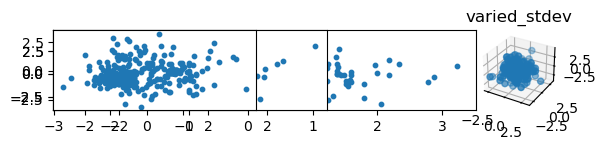

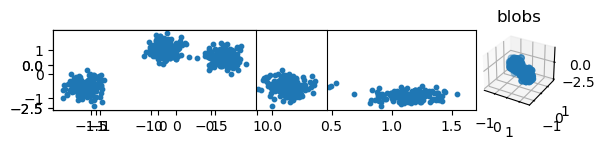

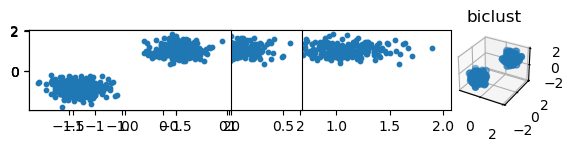

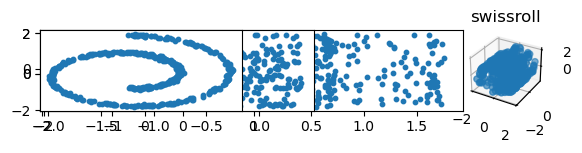

In [22]:
dataset_lst = [
    (varied[0],{'name' : 'varied_stdev'},),
    (blobs[0], {'name' : 'blobs'}),
    # (aniso[0], {'name' : 'aniso'}),    
    (biclusters, {'name' : 'biclust'}),  
    (swissrolldata[0], {'name' : 'swissroll'}),    
]

for i_dataset, (dataset_val, params_dict) in enumerate(dataset_lst):
    X = dataset_val

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # fig = plt.figure()
    fig = plt.figure(figsize=plt.figaspect(0.4))

    ax = fig.add_subplot(4, 1, 1,projection='3d')

    ax.scatter(X[:,0],X[:,1],X[:,2])

    plt.title(params_dict['name'])
    # plt.show()

    ax = fig.add_subplot(4, 2, 1)
    ax.scatter(X[:, 0], X[:, 1], s=10)

    ax = fig.add_subplot(4, 3, 1)
    ax.scatter(X[:, 1], X[:, 2], s=10)

    ax = fig.add_subplot(4, 4, 1)
    ax.scatter(X[:, 0], X[:, 2], s=10)

    # break
    # cov = EmpiricalCovariance().fit(X)
    # print(cov.covariance_)
    # plt.xlim(-2.5, 2.5)
    # plt.ylim(-2.5, 2.5)



In [14]:
# X[:,0].shape